# Template
## Load modules & Check PyTorch

In [1]:
# Import modules
import torch
import torch.nn as nn
import torch.optim as optim

import pandas as pd

# data processing
import random as r
from sys import exit
import numpy as np
import matplotlib.pyplot as plt

## Parameters

In [2]:
# Debugger: Aktiviert
debug_mode = True

## Preloaded Modules

In [3]:
def dict_to_markdown_table(data: dict, title: str = "Datenübersicht", include_index: bool = True, round_digits: int = 4):
    """
    Wandelt ein Dictionary mit Listenwerten in eine Markdown-Tabelle für Jupyter Notebooks um.
    
    - Schlüssel werden als Header genutzt
    - Erste Spalte ist ein Index, falls `include_index=True`
    - Einzelwerte werden als separate Tabelle unterhalb dargestellt
    - Zahlenwerte werden auf eine einstellbare Anzahl an Nachkommastellen gerundet

    :param data: Dictionary mit Key-Value-Paaren
    :param title: Überschrift für die Tabelle
    :param include_index: Falls True, wird eine Index-Spalte erstellt
    :param round_digits: Anzahl der Nachkommastellen, auf die Werte gerundet werden sollen
    :return: Markdown-String zur Anzeige in Jupyter
    """
    
    # Hilfsfunktion zum Runden von Zahlen
    def round_value(val):
        if isinstance(val, (int, float)):
            return round(val, round_digits)
        return val

    # Listen und einzelne Werte trennen
    list_data = {k: v for k, v in data.items() if isinstance(v, list)}
    single_values = {k: v for k, v in data.items() if not isinstance(v, list)}

    # Falls es Listen gibt, erstelle eine Tabelle mit Index
    if list_data:
        max_len = max(len(v) for v in list_data.values())  # Längste Liste bestimmen

        # Tabellenkopf
        md_table = f"### {title}\n\n"
        md_table += "| " + ("Index | " if include_index else "") + " | ".join(list_data.keys()) + " |\n"
        md_table += "|-" + ("-|" if include_index else "") + "-|".join(["-" * len(k) for k in list_data.keys()]) + "-|\n"

        # Datenzeilen
        for i in range(max_len):
            row = [str(i)] if include_index else []  # Index hinzufügen (optional)
            for key in list_data:
                if i < len(list_data[key]):
                    row.append(str(round_value(list_data[key][i])))
                else:
                    row.append("")  # Leere Werte für ungleich lange Listen
            md_table += "| " + " | ".join(row) + " |\n"
    
    else:
        md_table = ""

    # Einzelwerte als extra Tabelle darstellen
    if single_values:
        md_table += "\n\n#### Einzelwerte\n\n"
        md_table += "| " + " | ".join(single_values.keys()) + " |\n"
        md_table += "|-" + "-|".join(["-" * len(k) for k in single_values.keys()]) + "-|\n"
        md_table += "| " + " | ".join(map(lambda v: str(round_value(v)), single_values.values())) + " |\n"

    return Markdown(md_table)


def display_data_loss_table(data_dict, delta_sigma_pred, max_i):
    """
    Erstellt eine Markdown-Tabelle zur übersichtlichen Darstellung von Datenverlust.
    
    Unterstützt sowohl Python-Listen als auch NumPy-Arrays.
    
    :param data_dict: Dictionary mit `sigma_t` und `delta_sigma` (Listen oder np.arrays)
    :param delta_sigma_pred: Vorhergesagte Werte für `delta_sigma` (Liste oder np.array)
    :param max_i: Anzahl der Werte, die in der Tabelle angezeigt werden sollen
    """
    
    # Sicherstellen, dass `sigma_t` und `delta_sigma` existieren
    if "sigma_t" not in data_dict or "delta_sigma" not in data_dict or delta_sigma_pred is None:
        print("Fehler: `data_dict` oder `delta_sigma_pred` ist nicht korrekt definiert!")
        return

    # Konvertiere alle Werte zu Listen (falls sie NumPy-Arrays sind)
    def to_list(arr):
        return arr.tolist() if isinstance(arr, np.ndarray) else arr

    total_epsilon = to_list(data_dict["total_epsilon"])
    delta_epsilon = to_list(data_dict["delta_epsilon"])
    sigma_t = to_list(data_dict["sigma_t"])
    delta_sigma_true = to_list(data_dict["delta_sigma"])
    delta_sigma_pred = to_list(delta_sigma_pred.flatten())  # Falls `delta_sigma_pred` ein 2D-Array ist
    
    # Überprüfen, ob die Längen konsistent sind
    min_len = min(len(total_epsilon), len(sigma_t), len(delta_epsilon), len(delta_sigma_true), len(delta_sigma_pred), max_i)

    # Erstelle eine Tabelle für die übersichtliche Darstellung
    data_loss_table = {
        "total_epsilon" : list(total_epsilon[:min_len]), 
        "delta_epsilon" : list(delta_epsilon[:min_len]), 
        "sigma_t" : list(sigma_t[:min_len]), 
        "True delta_sigma": list(delta_sigma_true[:min_len]),
        "Predicted delta_sigma": list(delta_sigma_pred[:min_len]),
        "Test-Loss (True - Predicted)": list(np.round(np.array(delta_sigma_true[:min_len]) - np.array(delta_sigma_pred[:min_len]), 5))
    }

    # Markdown-Tabelle für bessere Darstellung in Jupyter
    display(dict_to_markdown_table(data_loss_table, title=f"Data-Loss bis sigma_{min_len-1}", include_index=True))

## Check for use of CONDA if available

In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

if device.type == 'cpu':
    device_num = 0
    print('No GPU available.')
else:
    device_num = torch.cuda.device_count()
    print('Device:', device, '-- Number of devices:', device_num)

No GPU available.


# Recurrent Neural Networks

Just as people do not have to think again each time about the things they have already learned, it is also possible to teach neural networks to recall knowledge they were being taught. This is done in so-called Recurrent Neural Networks (RNNs) with loops inside, which allow information to be retained. Currently the most used architectures of RNNs are Long short-term memory (LSTM) networks. LSTMs are RNNs that overcome the problem of long-term dependencies and thus have achieved the most state-of-the-art results in this area. In this exercise we will look at how to use LSTMs to predict future values using time series data sets.

## Data processing

In [5]:
import random

class Oedometer:
    def __init__(self, e_0: float = 1.00, C_c: float = 0.005, delta_epsilon: float = 0.0005, 
                 sigma_t: float = 1.00, max_n: int = 50, rand_epsilon:bool=False, **kwargs):
        self.max_n = max_n

        # Standardwerte als Listen setzen
        self.e_0 = [e_0]
        self.C_c = [C_c]
        self.sigma_t = [sigma_t]
        self.delta_epsilon = []
        self.total_epsilon = [0]

        # Initiale Listen für Berechnungen
        self.sigma_t = [sigma_t]
        self.delta_sigma = []
        self.e_s = []
        self.delta_epsilon = [delta_epsilon]
        
        # Dynamische Zuweisung von kwargs, falls vorhanden
        for key, value in kwargs.items():
            if hasattr(self, key):  # Nur vorhandene Attribute setzen
                setattr(self, key, [value])
        
        # Berechnungen durchführen
        self.__calc_sigma_t_p1()

        # Listenlängen anpassen
        self.__adjust_list_lengths()
        self.__calc_total_epsilon()

    def __adjust_list_lengths(self):
        """ Passt ALLE Listen-Attribute an `max_n` an. """
        attributes = ['e_0', 'C_c', 'delta_epsilon', 'sigma_t', 'sigma_t', 'delta_sigma', 'e_s']
        for attr in attributes:
            value_list = getattr(self, attr, [])
            current_length = len(value_list)

            if current_length > self.max_n:
                setattr(self, attr, value_list[:self.max_n])  # Kürzen
            elif current_length < self.max_n:
                setattr(self, attr, value_list + [value_list[-1] if value_list else 0] * (self.max_n - current_length))  # Auffüllen
    
    def __calc_total_epsilon(self):
        for i in range(len(self.delta_epsilon)-1):
            self.total_epsilon.append(self.total_epsilon[i] + self.delta_epsilon[i])            
    
    def __calc_e_s(self, sigma_t):
        """ Berechnet `e_s` aus `sigma_t`. """
        e_s = (1 + self.e_0[0]) / self.C_c[0] * sigma_t
        self.e_s.append(e_s)
        return e_s

    def __calc_sigma_t_p1(self):
        """ Berechnet `sigma_t` und `delta_sigma` für die nächsten Schritte. """
        for i in range(self.max_n):  # -1, weil sigma_t bereits gesetzt ist
            e_s = self.__calc_e_s(self.sigma_t[i])
            delta_sigma = e_s * self.delta_epsilon[0]
            sigma = self.sigma_t[i] + delta_sigma
            self.sigma_t.append(sigma)
            self.delta_sigma.append(delta_sigma)

def plot_input():
    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(data_dict_raw['sigma_t'], data_dict_raw['delta_sigma'], marker='o', linestyle='-', label='Sigma_0 = 1')
    
    # Formatting
    plt.xlabel('sigma_t')
    plt.ylabel('delta_simga')
    plt.title('Sigma_0 in relation to Sigma_1')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [6]:
i = 5000

oedo_para = {
    'max_n': 1, 
    'e_0': 1.0, 
    'C_c': 0.005,   
    'total_epsilon': 0,
    'e_s': 400.0
}

# Vorbereitung Tensoren
sigma_t = np.random.choice(range(1, 10000), size=i, replace=False)
delta_sigma = []
delta_epsilon = np.repeat(np.array(np.float64(0.0005)), i)
# delta_epsilon = np.random.uniform(0.0001, 0.001, size=i)
for i in range(i):
    oedo_para['sigma_t'] = sigma_t[i]
    oedo_para['delta_epsilon'] = delta_epsilon[i]
    oedo = Oedometer(**oedo_para)
    delta_sigma.append(round(oedo.delta_sigma[0], 2))

print('Anzahl Elemente delta_epsilon: ' + str(len(delta_epsilon)))
print('Anzahl Elemente sigma_t: ' + str(len(sigma_t)))
print('Anzahl Elemente delta_sigma: ' + str(len(delta_sigma)))

Anzahl Elemente delta_epsilon: 5000
Anzahl Elemente sigma_t: 5000
Anzahl Elemente delta_sigma: 5000


In [7]:
data = [['sigma_t'] + sigma_t.tolist(), ['delta_sigma'] + delta_sigma, ['delta_epsilon'] + delta_epsilon.tolist()]
import tabulate
table = tabulate.tabulate(data, tablefmt='html')
table

sigma_t,6051,1289,3562,8086,9581,357,8290,6011,1774,8361,7024,6447,3433,5524,3462,2483,9285,3257,7320,5637,3051,1173,9888,6092,9147,5035,9981,903,4386,2281,2240,8269,8723,3339,2416,9663,4796,3690,9355,9243,8323,4214,6871,3304,8605,910,4387,8905,138,5444,2181,9501,6198,3154,2716,6845,158,9709,8146,2647,5156,7911,5475,8958,8813,7061,7050,7261,8237,5023,736,5577,9318,914,741,8013,3238,5175,3292,6144,2439,7151,7944,9682,2049,6944,8005,9254,1118,2562,2782,893,2686,8283,4126,3291,3506,7671,4211,2251,5702,3512,8120,2731,8516,8292,3509,8947,8391,3549,229,9012,9536,4338,57,8100,9740,6218,2,9460,4394,5779,6191,7109,4978,8832,859,732,9122,3090,4470,1639,465,1806,6619,6363,5016,8300,2692,2558,3978,3633,5983,6169,9844,9186,6347,7771,1517,4680,6916,7691,7041,4890,4955,4315,5923,2547,1131,1965,8549,2663,2327,8392,759,8150,7319,344,8364,9481,2034,5370,8096,2751,6700,4190,8093,6507,5925,519,3481,1840,7326,1889,5807,5966,968,253,1065,5399,6745,196,2505,2492,5584,6075,7766,6362,1814,611,6258,4403,8769,7974,2898,6115,2638,7254,5952,4114,7603,3547,1979,8689,8322,6405,4282,7819,4994,3677,9164,1166,3835,8536,805,844,3599,4710,5321,5449,7396,8037,7378,1042,7331,7149,4910,7564,3163,9878,5122,4027,7346,6483,2871,5859,825,4913,4270,1391,5538,2390,1843,1535,4959,3526,6721,117,8451,3697,5044,8378,4390,5248,8376,6979,7237,4362,7430,1724,97,996,2054,3993,8339,8967,9778,4115,1753,738,1455,4171,9851,2928,7831,3319,8845,9812,9428,4557,5290,2380,8929,5003,9455,5438,8842,8295,8217,335,1349,6023,9066,1783,1463,3923,101,4878,1868,8291,2059,2057,6642,5282,590,1744,5688,7128,3837,5034,6481,3345,2119,6554,3373,9404,4941,5080,9389,2187,6262,6606,2852,3323,3400,381,1769,5847,8680,4674,4718,7338,9554,6699,4742,1222,9575,8020,4291,8218,5454,5318,1263,7727,7173,6751,2392,4894,9865,1332,6388,85,1252,3932,1294,7044,8521,337,4550,2087,6804,739,4341,7676,6266,6999,1345,2957,1667,4225,6937,4525,5712,9882,702,1137,3264,9602,6838,3792,3044,7281,2906,8285,5382,7520,4676,4830,8828,6016,6927,4201,3716,1525,4789,991,9276,70,2525,997,5790,4590,8773,2252,7477,5791,8700,49,1399,81,5415,4678,9859,8733,6373,8226,168,7434,7258,5400,3385,5627,5310,8209,9319,6741,9155,5351,4422,336,3606,8420,6,4716,4787,6920,6683,2335,475,9449,6960,5941,6124,9772,5053,293,8844,7293,1373,5284,4667,9820,6387,3287,9662,522,3081,1239,4319,9821,569,8421,5900,4419,8668,5032,6596,3114,2095,8875,8003,532,3894,8340,9195,62,5440,536,868,9510,6192,3537,8764,5657,299,4570,7362,1355,8325,9196,3370,4186,4762,8620,7502,6893,4179,1867,5307,361,3583,7994,9832,6224,1397,9730,6670,7303,6717,9677,4746,4443,3870,6641,1324,7709,5199,6225,1609,1012,1116,7981,2914,7490,2230,7658,7757,7047,7001,7339,8110,8714,8476,9256,6265,2076,7033,6776,1003,8938,850,3227,1450,2332,8707,6445,1271,2929,9306,7090,7647,4879,3739,9316,1738,1776,109,379,1782,5418,9124,7537,9574,5542,9424,5130,4522,261,6964,429,3781,635,1892,4852,4626,8204,4415,8518,3788,8082,2478,1494,6750,13,3224,1975,6228,4467,6595,282,8019,1812,8252,5504,3557,4049,489,9741,7933,1084,5828,2091,5264,791,2172,1386,9834,8079,3783,1997,9081,2222,9361,1727,1112,1133,9720,4372,8335,8574,5460,4864,3964,592,8695,4662,7137,4418,5968,9335,9,2869,3437,6974,9930,6415,9824,1509,418,7472,1932,4579,5903,3650,8038,941,8258,1704,4963,157,9049,9129,1290,3906,362,3072,9374,9266,2982,9227,8474,8881,1330,6216,4566,6209,504,1413,5198,6863,2504,925,7817,7611,2643,74,2102,8499,1561,709,783,3899,7655,6909,7142,8633,5612,9657,8265,5152,3043,1470,1672,1488,9303,3933,3904,8817,5197,7720,8732,6398,4961,2180,3692,6070,7313,766,1423,2735,5101,2831,2456,6664,567,5388,1602,2805,2937,1408,3715,9883,24,8264,1344,3617,574,8207,3359,5643,5405,3989,6661,2997,7928,2298,9167,1773,2345,1357,8262,1707,1937,3411,958,6589,8352,8022,3455,6846,8094,482,1198,6547,8327,5732,2903,4986,8417,2338,5652,8930,4086,6926,3281,4897,5614,322,4016,6816,4481,5565,1943,2014,1578,5235,9776,8435,8688,6992,571,6444,7283,1426,1988,9110,9726,7456,9648,6472,7893,3630,7350,4917,7441,856,6991,7087,1766,7828,3920,2051,4629,940,9401,259,6465,696,4343,4

In [8]:
from sklearn.preprocessing import MinMaxScaler

data = {
    'input1': sigma_t,
    'input2': delta_epsilon,
    'output': delta_sigma
}
df = pd.DataFrame(data)

# Normalisierung
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# Zurück in DataFrame
df_scaled = pd.DataFrame(scaled_data, columns=df.columns)
df_scaled

,input1,input2,output
0,0.605121,0.0,0.605121
1,0.128826,0.0,0.128826
2,0.356171,0.0,0.356171
3,0.808662,0.0,0.808662
4,0.958192,0.0,0.958192
...,...,...,...
4995,0.760452,0.0,0.760452
4996,0.801460,0.0,0.801460
4997,0.692238,0.0,0.692238
4998,0.868674,0.0,0.868674


## Auszug aus Tutorial 6

    # Create sequences
    # Function to create sequences of input (passenger of train_window months) and ...
    # ... output passenger of train_window+1 month
    
    def create_inout_sequences(input_data, tw):
        inout_seq = []
        L = len(input_data)
        for i in range(L-tw):
            train_seq = input_data[i:i+tw]
            train_label = input_data[i+tw:i+tw+1]
            inout_seq.append((train_seq ,train_<label))
        return inout_seq
    
    # Set an appropiate Train window
    # TODO start**
    train_window = 24
    
    # Create sequences 
    trva_inout_seq = create_inout_sequences(trva_data_normalized, train_window)
    
    # Print the first 3 sequences
    print(trva_inout_seq[:3])

In [9]:
import numpy as np
import torch

lookback=1

def create_dataset(df, lookback=1):
    """
    Erzeugt die Eingabe- und Ziel-Datensätze für ein LSTM.
    
    lookback definiert hier, wie viele vergangene Zeitschritte
    (Train Window / Sequences im Tutorial) das Modell als Input
    für jede Vorhersage erhält. Dadurch entsteht die nötige
    3D-Form (batch_size, seq_length, input_size), die ein LSTM erwartet,
    um zeitliche Abhängigkeiten zu lernen.
    """
    X, y = [], []
    for i in range(len(df) - lookback):
        # Wir nehmen hier 'lookback' Zeilen als eine Sequenz,
        # damit das LSTM-Modell weiß, wie weit es in die Vergangenheit
        # zurückschauen muss. Ohne diese Sequenz-Dimension (seq_length)
        # wäre die Eingabe nur eine 2D-Matrix und das LSTM könnte
        # keine zeitlichen Muster erfassen.
        seq = df.iloc[i:i+lookback, :-1].values
        X.append(seq)
        
        # Zielwert: der Wert direkt nach dieser Sequenz
        y.append(df.iloc[i+lookback, -1])
    
    # Rückgabe als Tensor mit Form (batch_size, seq_length, input_size) und (batch_size,)
    return torch.tensor(np.array(X), dtype=torch.float32), \
           torch.tensor(np.array(y), dtype=torch.float32)

X, y = create_dataset(df_scaled, lookback)
X_input_all = df_scaled.iloc[lookback:, :-1].to_numpy(dtype=np.float32)

print(np.shape(X))  # z.B. (4997, 3, 2)

# Falls lookback=1, wäre X anfangs (5000, 1, 2).
# Mit squeeze() könnte man die mittlere Dimension entfernen,
# aber für LSTM brauchen wir sie genau so:
# X = X.squeeze()
print(np.shape(X))

torch.Size([4999, 1, 2])
torch.Size([4999, 1, 2])


In [10]:
# --- Aufteilen in Training (2/3) und Test (1/3) ---
train_size = int(X.shape[0] * 2/3)
X_train = X[:train_size]
y_train = y[:train_size].view(-1, 1)  # als (batch_size, 1)
X_test  = X[train_size:]
y_test  = y[train_size:].view(-1, 1)

X_input_train = X_input_all[:train_size]
X_input_test  = X_input_all[train_size:]

print("Shapes:")
print("  X_train:", X_train.shape, "y_train:", y_train.shape, "X_input_train:", X_input_train.shape)
print("  X_test: ", X_test.shape,  "y_test: ", y_test.shape,  "X_input_test: ",  X_input_test.shape)

Shapes:
  X_train: torch.Size([3332, 1, 2]) y_train: torch.Size([3332, 1]) X_input_train: (3332, 2)
  X_test:  torch.Size([1667, 1, 2]) y_test:  torch.Size([1667, 1]) X_input_test:  (1667, 2)


In [11]:
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        out = self.fc(hn[-1])
        return out

# Modell initialisieren
model = LSTMModel(input_size=2, hidden_size=50, num_layers=2, output_size=1)


In [12]:
import torch.optim as optim

# Hyperparameter
input_size = X_train.shape[2]  # Anzahl der Input-Features
hidden_size = 5  # Die Anzahl der Neuronen im LSTM
num_layers = 2  # Anzahl der LSTM-Schichten
output_size = 1  # Output ist eine einzelne Zahl (z. B. Vorhersage)

# Modell, Loss und Optimizer
model = LSTMModel(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Frühzeitige Beendigung: Überwache den Verlust auf den Validierungsdaten
best_val_loss = float('inf')  # Initialer hoher Verlust
patience = 20  # Anzahl der Epochen ohne Verbesserung, bevor das Training gestoppt wird
patience_counter = 0  # Zähler für die Anzahl der Epochen ohne Verbesserung

# Liste zum Speichern der Loss-Werte
losses = []

# Training
epochs = 1000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)  # Verlust auf den Trainingsdaten
    loss.backward()
    optimizer.step()

    # Verlust speichern
    losses.append(loss.item())

    # Validierungsverlust berechnen
    model.eval()  # Modell in Evaluierungsmodus setzen
    with torch.no_grad():
        val_outputs = model(X_test)  # Vorhersagen auf den Validierungsdaten
        val_loss = criterion(val_outputs, y_test)  # Verlust auf den Validierungsdaten

    # Frühzeitige Beendigung überwachen
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0  # Reset der Geduld
    else:
        patience_counter += 1

    # Wenn keine Verbesserung erfolgt, abbrechen
    if patience_counter >= patience:
        print(f"Frühzeitige Beendigung nach {epoch + 1} Epochen wegen fehlender Verbesserung.")
        break

    # Ausgabe der Verlustinformationen
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {loss.item()}, Validation Loss: {val_loss.item()}')

Epoch 10/1000, Train Loss: 1.084216594696045, Validation Loss: 1.0818229913711548
Epoch 20/1000, Train Loss: 1.0396728515625, Validation Loss: 1.0373982191085815
Epoch 30/1000, Train Loss: 0.9968220591545105, Validation Loss: 0.9946303963661194
Epoch 40/1000, Train Loss: 0.9551624655723572, Validation Loss: 0.95299232006073
Epoch 50/1000, Train Loss: 0.9139982461929321, Validation Loss: 0.9117724299430847
Epoch 60/1000, Train Loss: 0.8725055456161499, Validation Loss: 0.8701364398002625
Epoch 70/1000, Train Loss: 0.829847514629364, Validation Loss: 0.8272552490234375
Epoch 80/1000, Train Loss: 0.7853434085845947, Validation Loss: 0.7824683785438538
Epoch 90/1000, Train Loss: 0.7385393977165222, Validation Loss: 0.7353439927101135
Epoch 100/1000, Train Loss: 0.6892065405845642, Validation Loss: 0.6856746077537537
Epoch 110/1000, Train Loss: 0.6373463869094849, Validation Loss: 0.6334856152534485
Epoch 120/1000, Train Loss: 0.583219587802887, Validation Loss: 0.5790649652481079
Epoch 130

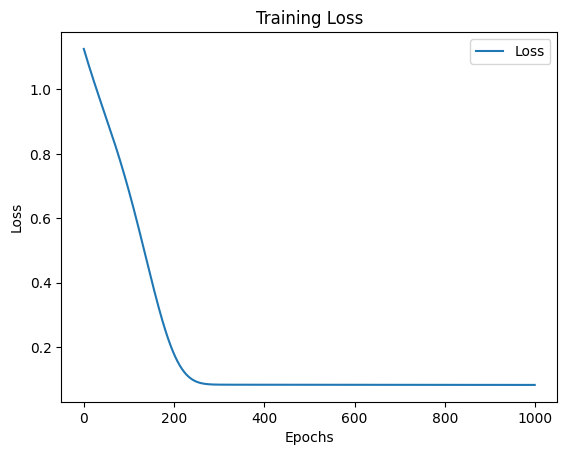

In [13]:
import matplotlib.pyplot as plt
# Plot der Losskurve
plt.plot(range(epochs), losses, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

In [14]:
def evaluate_model(model, X_eval, y_eval, X_input_eval, scaler, max_print=5):
    """
    Führt das trainierte Modell auf X_eval aus,
    berechnet den MSE auf dem normierten Datensatz und
    zeigt für die ersten `max_print` Samples:
      - die unskalierten Lookback-Input-Sequenzen
      - den unskalierten aktuellen Input (zum Real-Wert)
      - die unskalierten Vorhersagen
      - die unskalierten Realwerte
    """

    model.eval()
    with torch.no_grad():
        # Vorhersagen im skalierten Raum
        preds_scaled = model(X_eval).cpu().numpy().ravel()
        y_scaled     = y_eval.cpu().numpy().ravel()
        mse_scaled   = np.mean((preds_scaled - y_scaled)**2)
        print(f"Evaluierung auf {X_eval.shape[0]} Proben → MSE (skaliert): {mse_scaled:.6f}\n")

        # Min/Max für jeden Kanal (input1, input2, output)
        mins = scaler.data_min_    # [min_input1, min_input2, min_output]
        maxs = scaler.data_max_    # [max_input1, max_input2, max_output]

        for i in range(min(max_print, len(preds_scaled))):
            # --- Unskalierte Lookback-Sequenz ---
            seq_scaled = X_eval[i].cpu().numpy()           # shape (lookback, 2)
            dummy_out  = np.zeros((seq_scaled.shape[0],1))
            stacked    = np.hstack([seq_scaled, dummy_out])  # (lookback, 3)
            seq_unscaled = scaler.inverse_transform(stacked)[:, :2]  # nur Input-Spalten

            # --- Unskalierter aktueller Input ---
            curr_scaled = X_input_eval[i]                  # shape (2,)
            curr_unscaled = [
                curr_scaled[j] * (maxs[j] - mins[j]) + mins[j]
                for j in range(2)
            ]

            # --- Unskalierte Vorhersage und Realwert ---
            pred_unscaled = preds_scaled[i] * (maxs[2] - mins[2]) + mins[2]
            real_unscaled = y_scaled[i]      * (maxs[2] - mins[2]) + mins[2]

            # --- Ausgabe ---
            print(f"Sample {i}:")
            print(f"  Lookback-Sequenz (unskaliert):")
            for t, vals in enumerate(seq_unscaled[::-1], 1):
                print(f"    t-{t}: {vals.tolist()}")
            print(f"  Aktueller Input (unskaliert): {curr_unscaled}")
            print(f"  Vorhersage = {pred_unscaled:.4f}, Real = {real_unscaled:.4f}\n")

    return mse_scaled

mse_test = evaluate_model(model, X_test, y_test, X_input_test, scaler)

Evaluierung auf 1667 Proben → MSE (skaliert): 0.082382

Sample 0:
  Lookback-Sequenz (unskaliert):
    t-1: [3143.0001440048213, 0.0005]
  Aktueller Input (unskaliert): [np.float64(8788.000168681145), np.float64(0.0005)]
  Vorhersage = 975.7158, Real = 1757.6000

Sample 1:
  Lookback-Sequenz (unskaliert):
    t-1: [8788.000168681145, 0.0005]
  Aktueller Input (unskaliert): [np.float64(2137.999993532896), np.float64(0.0005)]
  Vorhersage = 1067.8637, Real = 427.6000

Sample 2:
  Lookback-Sequenz (unskaliert):
    t-1: [2137.999993532896, 0.0005]
  Aktueller Input (unskaliert): [np.float64(9323.999772191048), np.float64(0.0005)]
  Vorhersage = 956.3250, Real = 1864.8000

Sample 3:
  Lookback-Sequenz (unskaliert):
    t-1: [9323.999772191048, 0.0005]
  Aktueller Input (unskaliert): [np.float64(9292.000267267227), np.float64(0.0005)]
  Vorhersage = 1075.2682, Real = 1858.4001

Sample 4:
  Lookback-Sequenz (unskaliert):
    t-1: [9292.000267267227, 0.0005]
  Aktueller Input (unskaliert): [n

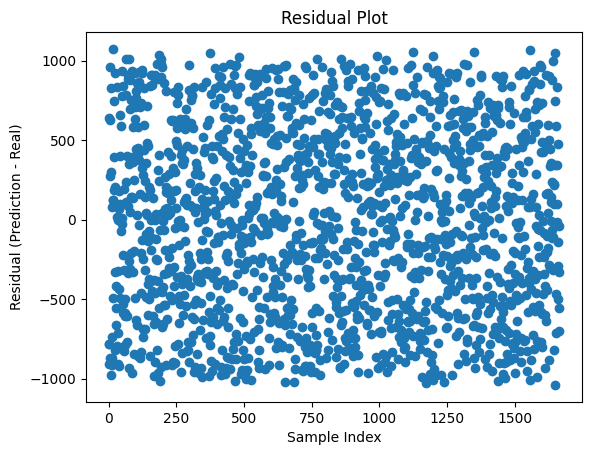

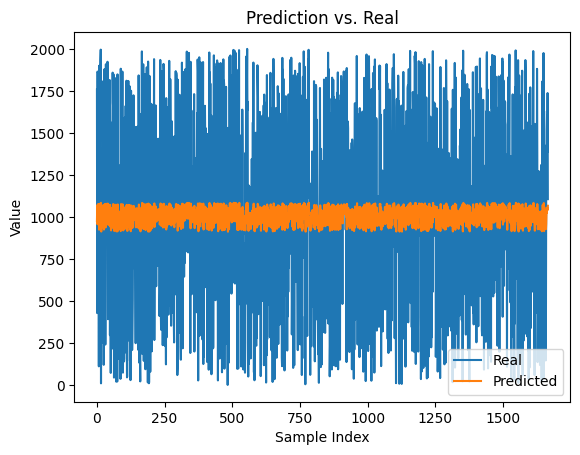

In [15]:
import numpy as np
import matplotlib.pyplot as plt

def plot_residuals(y_true, y_pred, max_points=None):
    """
    Plots the residuals (y_pred - y_true) for each sample.
    If max_points is set, only the first max_points residuals are shown.
    Converts lists to numpy arrays for subtraction.
    """
    # Ensure numpy arrays
    y_true_arr = np.array(y_true, dtype=float)
    y_pred_arr = np.array(y_pred, dtype=float)
    residuals = y_pred_arr - y_true_arr

    if max_points is not None:
        residuals = residuals[:max_points]
    plt.figure()
    plt.scatter(range(len(residuals)), residuals)
    plt.xlabel('Sample Index')
    plt.ylabel('Residual (Prediction - Real)')
    plt.title('Residual Plot')
    plt.show()

def plot_pred_vs_real(y_true, y_pred, max_points=None):
    """
    Plots predicted vs. real values.
    If max_points is set, only the first max_points points are plotted.
    Converts lists to numpy arrays for plotting.
    """
    # Sicherstellen von numpy arrays
    y_true_arr = np.array(y_true, dtype=float)
    y_pred_arr = np.array(y_pred, dtype=float)

    if max_points is not None:
        y_true_arr = y_true_arr[:max_points]
        y_pred_arr = y_pred_arr[:max_points]
    plt.figure()
    plt.plot(y_true_arr, label='Real')
    plt.plot(y_pred_arr, label='Predicted')
    plt.xlabel('Sample Index')
    plt.ylabel('Value')
    plt.title('Prediction vs. Real')
    plt.legend()
    plt.show()

y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    preds_scaled = model(X_test).cpu().numpy().ravel()
    y_scaled     = y_test.cpu().numpy().ravel()

    # Min/Max für jeden Kanal (input1, input2, output)
    mins = scaler.data_min_    # [min_input1, min_input2, min_output]
    maxs = scaler.data_max_    # [max_input1, max_input2, max_output]
for i in range(len(preds_scaled)):
    pred_unscaled = preds_scaled[i] * (maxs[2] - mins[2]) + mins[2]
    real_unscaled = y_scaled[i]      * (maxs[2] - mins[2]) + mins[2]
    y_true.append(real_unscaled)
    y_pred.append(pred_unscaled)

plot_residuals(y_true, y_pred)
plot_pred_vs_real(y_true, y_pred)